In [1]:
import os 

import torch
import torch.nn as nn 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from captum.attr import IntegratedGradients
from captum.attr import visualization as viz

from helpers import load_experiment

default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

In [2]:
dm, model = load_experiment("/home/danis/Projects/AlphaCaption/AutoConceptBottleneck/autoconcept/outputs/2023-05-03/04-28-27")

Fetching configuration...
Loading datamodule...


[nltk_data] Downloading package wordnet to /home/danis/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/home/danis/anaconda3/envs/bottleneck/lib/python3.10/site-packages/torchtext/data/utils.py:105: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(
100%|██████████| 2700/2700 [00:00<00:00, 9148.70it/s]


Len of vocab:  54
Max len of caption:  16
Index for <pad>: [0]
Loading model


/home/danis/anaconda3/envs/bottleneck/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'criterion' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['criterion'])`.
  rank_zero_warn(


In [3]:
train_loader = dm.train_dataloader()
train_set = train_loader.dataset

In [4]:
def integrated_gradients_sample(model, sample):
    image, report, target = sample["image"], sample["report"], sample["target"]
    image_np = image.permute((1, 2, 0)).numpy() 

    print("Image:")
    plt.imshow(image_np)
    plt.show()

    print(f'Caption: "{report}"')
    print("Target: ", target)

    image = image.unsqueeze(0).cuda()
    prediction = model.main.inference(image)
    print("Prediction: ", prediction.cpu().detach())

    integrated_gradients = IntegratedGradients(model.main.inference)
    attributions_ig = integrated_gradients.attribute(image, target=0, n_steps=30)
    attributions_ig = attributions_ig.squeeze().cpu().detach().numpy()
    
    print("Integrated Gradients")
    _ = viz.visualize_image_attr(
        np.transpose(attributions_ig, (1,2,0)),
        np.transpose(image.unsqueeze(0).squeeze().cpu().detach().numpy(), (1,2,0)),
        method='heat_map',
        cmap=default_cmap,
        show_colorbar=True,
        sign='positive',
        outlier_perc=1
    )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image:


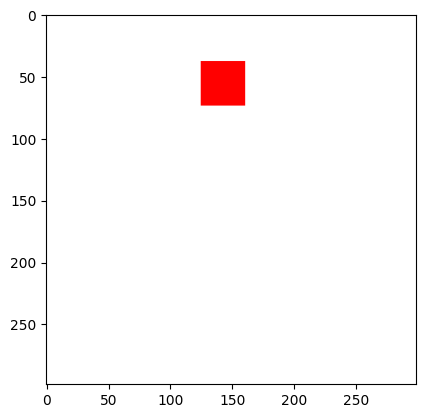

Caption: "this shape is quadratic crimson locate in up left unrotate solid white background"
Target:  tensor(0)
Prediction:  tensor([[0.7042, 0.0181, 0.0628, 0.0197, 0.0207, 0.0360, 0.0361, 0.0328, 0.0695]])
Integrated Gradients


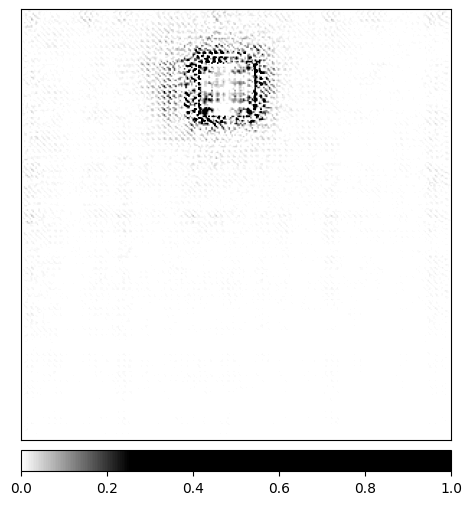

In [6]:
sample = train_set[0]
integrated_gradients_sample(model, sample)